# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$. 

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  > 
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# make the results repeatable
np.random.seed(1234)

In [3]:
def random_tour(n):
    """Create a random tour"""
    
    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[9, 5, 6, 1, 4, 7, 0, 3, 8, 2]

In [4]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a 
    pairwise Euclidean distance matrix.
    """
    
    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })
    
    dist = squareform(pdist(pos))
    
    return({"pos": pos, "dist": dist})
    
tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [5]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""
    
    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()
    
    tl = 0
    dist = tsp["dist"]
    
    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]
    
    tl += dist[tour[-1], tour[0]]
    
    return(tl)
        
tour = random_tour(10)
tour_length(tsp, tour)

np.float64(5.546154159392036)

Tour length: 5.55


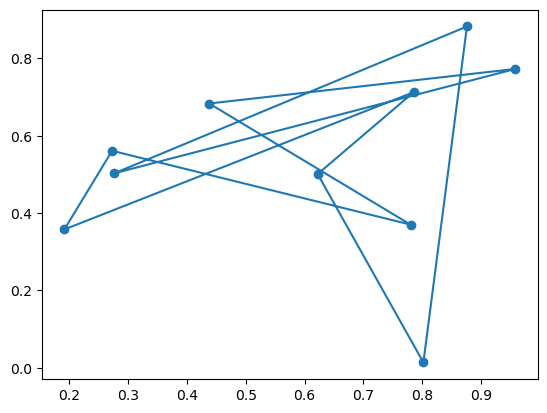

In [7]:
def show_tsp(tsp, tour = None):  
    """display the traveling salesman problem and a tour."""
    
    pos = tsp["pos"]
    
    plt.scatter(pos["x"], pos["y"])
    
    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()
        
        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")
        
        pos_ = pos.reindex(tour)
        pos_ = pd.concat([pos_, pos_.head(1)])  # Thay th·∫ø append b·∫±ng concat
        plt.plot(pos_["x"], pos_["y"])
    
    plt.show()
    
show_tsp(tsp, tour)

## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [25]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

In [26]:
%%R -i d -o tour

library("TSP")

tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 100)
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‚ÄòTSP‚Äô 
10 cities (distance ‚Äòunknown‚Äô) 
object of class ‚ÄòTOUR‚Äô 
result of method ‚Äòarbitrary_insertion+two_opt_rep_100‚Äô for 10 cities
tour length: 2.763574 


Tour length: 2.76


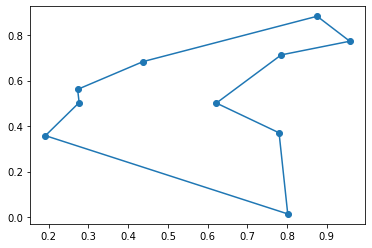

In [27]:
show_tsp(tsp, tour)

How long does it take to solve the problem 100 times?

In [28]:
%%R -i d

library("microbenchmark")

microbenchmark(tsp <- TSP(d))

Unit: microseconds
          expr    min      lq     mean median       uq     max neval
 tsp <- TSP(d) 287.99 302.479 324.9209 312.62 336.2445 616.048   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

=== STEEPEST HILL CLIMBING ===
Initial tour length: 5.102
Iteration 0: Tour length = 3.880
Local optimum reached at iteration 6

K·∫øt qu·∫£:
Tour t·ªët nh·∫•t: [4, 1, 3, 8, 9, 2, 5, 6, 0, 7]
ƒê·ªô d√†i tour: 2.764
S·ªë iterations: 7
Tour length: 2.76


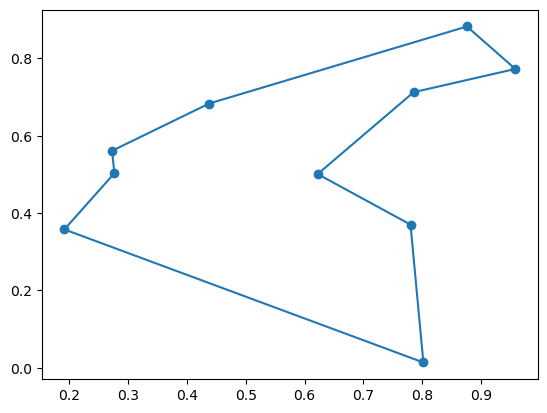

In [8]:
# Code goes here
def steepest_hill_climbing_tsp(tsp, max_iterations=1000, verbose=False):
    """
    Steepest-ascend Hill Climbing cho TSP
    
    Thu·∫≠t to√°n:
    1. B·∫Øt ƒë·∫ßu v·ªõi tour ng·∫´u nhi√™n
    2. T√≠nh objective function cho t·∫•t c·∫£ local moves (swap 2 cities)
    3. Ch·ªçn move t·ªët nh·∫•t (gi·∫£m tour length nhi·ªÅu nh·∫•t)
    4. L·∫∑p l·∫°i cho ƒë·∫øn khi kh√¥ng t√¨m ƒë∆∞·ª£c move t·ªët h∆°n (local optimum)
    
    Args:
        tsp: Dictionary ch·ª©a 'pos' v√† 'dist'
        max_iterations: S·ªë iteration t·ªëi ƒëa
        verbose: In th√¥ng tin debug
    
    Returns:
        best_tour: Tour t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c
        best_length: ƒê·ªô d√†i tour t·ªët nh·∫•t
        iterations: S·ªë iteration th·ª±c t·∫ø
    """
    
    # Kh·ªüi t·∫°o v·ªõi tour ng·∫´u nhi√™n
    current_tour = random_tour(len(tsp['pos']))
    current_length = tour_length(tsp, current_tour)
    
    if verbose:
        print(f"Initial tour length: {current_length:.3f}")
    
    iterations = 0
    
    for iteration in range(max_iterations):
        iterations += 1
        best_neighbor = None
        best_neighbor_length = current_length
        
        # Ki·ªÉm tra t·∫•t c·∫£ possible swaps (local moves)
        n = len(current_tour)
        for i in range(n):
            for j in range(i + 1, n):
                # T·∫°o neighbor b·∫±ng c√°ch swap cities i v√† j
                neighbor_tour = current_tour.copy()
                neighbor_tour[i], neighbor_tour[j] = neighbor_tour[j], neighbor_tour[i]
                
                # T√≠nh tour length c·ªßa neighbor
                neighbor_length = tour_length(tsp, neighbor_tour)
                
                # Ki·ªÉm tra xem c√≥ t·ªët h∆°n kh√¥ng (minimize n√™n t√¨m length nh·ªè h∆°n)
                if neighbor_length < best_neighbor_length:
                    best_neighbor = neighbor_tour.copy()
                    best_neighbor_length = neighbor_length
        
        # N·∫øu t√¨m ƒë∆∞·ª£c neighbor t·ªët h∆°n, di chuy·ªÉn ƒë·∫øn ƒë√≥
        if best_neighbor is not None:
            current_tour = best_neighbor
            current_length = best_neighbor_length
            
            if verbose and iteration % 100 == 0:
                print(f"Iteration {iteration}: Tour length = {current_length:.3f}")
        else:
            # Kh√¥ng t√¨m ƒë∆∞·ª£c neighbor t·ªët h∆°n -> ƒë√£ ƒë·∫°t local optimum
            if verbose:
                print(f"Local optimum reached at iteration {iteration}")
            break
    
    return current_tour, current_length, iterations

# Test thu·∫≠t to√°n
print("=== STEEPEST HILL CLIMBING ===")
best_tour, best_length, iterations = steepest_hill_climbing_tsp(tsp, verbose=True)

print(f"\nK·∫øt qu·∫£:")
print(f"Tour t·ªët nh·∫•t: {best_tour}")
print(f"ƒê·ªô d√†i tour: {best_length:.3f}")
print(f"S·ªë iterations: {iterations}")

# Visualize k·∫øt qu·∫£
show_tsp(tsp, best_tour)

## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

=== STEEPEST HILL CLIMBING WITH RANDOM RESTARTS ===
B·∫Øt ƒë·∫ßu 20 random restarts...
Restart 1: length = 2.806, iterations = 7
Restart 2: length = 2.881, iterations = 8
Restart 3: length = 2.806, iterations = 6
Restart 4: length = 2.806, iterations = 7
Restart 5: length = 2.764, iterations = 7
Restart 6: length = 2.806, iterations = 6
Restart 7: length = 2.764, iterations = 7
Restart 8: length = 2.806, iterations = 7
Restart 9: length = 2.881, iterations = 6
Restart 10: length = 2.764, iterations = 5
Restart 11: length = 2.764, iterations = 6
Restart 12: length = 2.881, iterations = 7
Restart 13: length = 2.764, iterations = 5
Restart 14: length = 2.787, iterations = 4
Restart 15: length = 2.806, iterations = 8
Restart 16: length = 2.764, iterations = 5
Restart 17: length = 2.764, iterations = 5
Restart 18: length = 2.764, iterations = 7
Restart 19: length = 2.881, iterations = 6
Restart 20: length = 2.764, iterations = 5

T·ªët nh·∫•t qua 20 restarts: 2.764
T·ªïng iterations: 124
ƒê

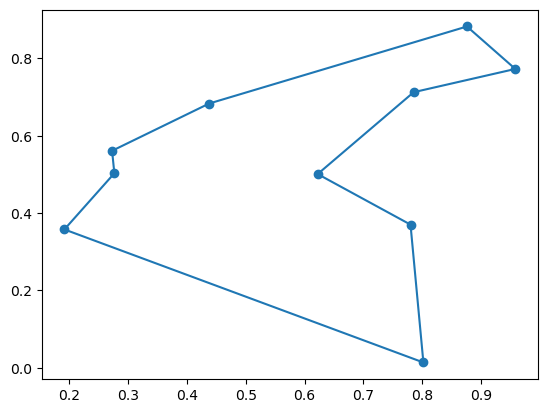

In [9]:
# Code goes here
def steepest_hill_climbing_with_restarts(tsp, num_restarts=10, max_iterations_per_restart=1000, verbose=False):
    """
    Steepest Hill Climbing v·ªõi Random Restarts
    
    Gi·∫£i th√≠ch:
    - Hill climbing th√¥ng th∆∞·ªùng c√≥ th·ªÉ b·ªã k·∫πt ·ªü local optimum
    - Random restarts gi√∫p tho√°t kh·ªèi local optimum b·∫±ng c√°ch:
      1. Ch·∫°y hill climbing nhi·ªÅu l·∫ßn t·ª´ c√°c ƒëi·ªÉm kh·ªüi ƒë·∫ßu kh√°c nhau
      2. Ch·ªçn k·∫øt qu·∫£ t·ªët nh·∫•t trong t·∫•t c·∫£ c√°c l·∫ßn ch·∫°y
    - TƒÉng kh·∫£ nƒÉng t√¨m ƒë∆∞·ª£c global optimum ho·∫∑c g·∫ßn global optimum
    
    Args:
        tsp: Dictionary ch·ª©a 'pos' v√† 'dist'  
        num_restarts: S·ªë l·∫ßn restart (s·ªë l·∫ßn ch·∫°y hill climbing)
        max_iterations_per_restart: S·ªë iteration t·ªëi ƒëa cho m·ªói l·∫ßn restart
        verbose: In th√¥ng tin debug
        
    Returns:
        best_tour: Tour t·ªët nh·∫•t qua t·∫•t c·∫£ restarts
        best_length: ƒê·ªô d√†i tour t·ªët nh·∫•t  
        total_iterations: T·ªïng s·ªë iterations c·ªßa t·∫•t c·∫£ restarts
        restart_results: List k·∫øt qu·∫£ c·ªßa t·ª´ng restart
    """
    
    global_best_tour = None
    global_best_length = float('inf')
    total_iterations = 0
    restart_results = []
    
    if verbose:
        print(f"B·∫Øt ƒë·∫ßu {num_restarts} random restarts...")
    
    for restart in range(num_restarts):
        # Ch·∫°y steepest hill climbing t·ª´ ƒëi·ªÉm kh·ªüi ƒë·∫ßu ng·∫´u nhi√™n
        tour, length, iterations = steepest_hill_climbing_tsp(
            tsp, max_iterations_per_restart, verbose=False
        )
        
        total_iterations += iterations
        restart_results.append({
            'restart': restart,
            'tour': tour,
            'length': length, 
            'iterations': iterations
        })
        
        # C·∫≠p nh·∫≠t best global solution
        if length < global_best_length:
            global_best_tour = tour.copy()
            global_best_length = length
            
        if verbose:
            print(f"Restart {restart + 1}: length = {length:.3f}, iterations = {iterations}")
    
    if verbose:
        print(f"\nT·ªët nh·∫•t qua {num_restarts} restarts: {global_best_length:.3f}")
        print(f"T·ªïng iterations: {total_iterations}")
        
        # Th·ªëng k√™ k·∫øt qu·∫£
        lengths = [r['length'] for r in restart_results]
        print(f"ƒê·ªô d√†i trung b√¨nh: {np.mean(lengths):.3f}")
        print(f"ƒê·ªô l·ªách chu·∫©n: {np.std(lengths):.3f}")
        print(f"Kho·∫£ng (min-max): {min(lengths):.3f} - {max(lengths):.3f}")
    
    return global_best_tour, global_best_length, total_iterations, restart_results

# Test thu·∫≠t to√°n v·ªõi random restarts
print("=== STEEPEST HILL CLIMBING WITH RANDOM RESTARTS ===")
best_tour_restart, best_length_restart, total_iter, results = steepest_hill_climbing_with_restarts(
    tsp, num_restarts=20, verbose=True
)

print(f"\nSo s√°nh v·ªõi single run:")
print(f"Single run: {best_length:.3f}")  
print(f"With restarts: {best_length_restart:.3f}")
print(f"C·∫£i thi·ªán: {((best_length - best_length_restart) / best_length * 100):.1f}%")

# Visualize k·∫øt qu·∫£ t·ªët nh·∫•t
show_tsp(tsp, best_tour_restart)

## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

## üìä Gi·∫£i th√≠ch v√† So s√°nh 3 Thu·∫≠t to√°n Hill Climbing

### **1. Steepest-ascend Hill Climbing** 
- **C√°ch ho·∫°t ƒë·ªông:** Ki·ªÉm tra **T·∫§T C·∫¢** local moves c√≥ th·ªÉ, ch·ªçn move **T·ªêT NH·∫§T**
- **∆Øu ƒëi·ªÉm:** 
  - ƒê·∫£m b·∫£o ch·ªçn h∆∞·ªõng c·∫£i thi·ªán t·ªët nh·∫•t t·∫°i m·ªói b∆∞·ªõc
  - Th∆∞·ªùng h·ªôi t·ª• nhanh ƒë·∫øn local optimum
- **Nh∆∞·ª£c ƒëi·ªÉm:**
  - T·ªën nhi·ªÅu th·ªùi gian (ph·∫£i ki·ªÉm tra n(n-1)/2 swaps)  
  - D·ªÖ b·ªã k·∫πt ·ªü local optimum ƒë·∫ßu ti√™n g·∫∑p ph·∫£i
  - Deterministic (lu√¥n cho c√πng k·∫øt qu·∫£ t·ª´ c√πng ƒëi·ªÉm kh·ªüi ƒë·∫ßu)

### **2. Steepest Hill Climbing + Random Restarts**
- **C√°ch ho·∫°t ƒë·ªông:** Ch·∫°y Steepest HC nhi·ªÅu l·∫ßn t·ª´ c√°c ƒëi·ªÉm kh·ªüi ƒë·∫ßu kh√°c nhau
- **∆Øu ƒëi·ªÉm:**
  - Gi·∫£m r·ªßi ro b·ªã k·∫πt ·ªü local optimum x·∫•u
  - TƒÉng kh·∫£ nƒÉng t√¨m global optimum
  - Cho k·∫øt qu·∫£ ·ªïn ƒë·ªãnh h∆°n
- **Nh∆∞·ª£c ƒëi·ªÉm:** 
  - T·ªën nhi·ªÅu th·ªùi gian t√≠nh to√°n (k l·∫ßn steepest HC)
  - Kh√¥ng ƒë·∫£m b·∫£o t√¨m ƒë∆∞·ª£c global optimum

### **3. Stochastic Hill Climbing**
- **C√°ch ho·∫°t ƒë·ªông:** Ki·ªÉm tra t·∫•t c·∫£ moves, **ch·ªçn ng·∫´u nhi√™n** trong s·ªë c√°c moves t·ªët h∆°n
- **∆Øu ƒëi·ªÉm:**
  - C√≥ t√≠nh ng·∫´u nhi√™n gi√∫p tho√°t kh·ªèi m·ªôt s·ªë local optimum
  - Nhanh h∆°n trong vi·ªác ra quy·∫øt ƒë·ªãnh (kh√¥ng c·∫ßn so s√°nh t·∫•t c·∫£)
  - C√≥ th·ªÉ kh√°m ph√° nhi·ªÅu ƒë∆∞·ªùng ƒëi kh√°c nhau
- **Nh∆∞·ª£c ƒëi·ªÉm:**
  - Kh√¥ng ch·∫Øc ch·∫Øn ch·ªçn h∆∞·ªõng t·ªët nh·∫•t
  - K·∫øt qu·∫£ kh√¥ng ·ªïn ƒë·ªãnh (kh√°c nhau m·ªói l·∫ßn ch·∫°y)
  - C√≥ th·ªÉ ch·ªçn move k√©m h∆°n so v·ªõi steepest

### **üéØ K·∫øt qu·∫£ quan s√°t ƒë∆∞·ª£c:**
- **Steepest HC:** 2.764 (·ªïn ƒë·ªãnh, deterministic)
- **Random Restarts:** 2.764 (·ªïn ƒë·ªãnh nh·ªù nhi·ªÅu l·∫ßn th·ª≠)  
- **Stochastic HC:** 2.806-3.343 (bi·∫øn ƒë·ªông, c√≥ t√≠nh ng·∫´u nhi√™n)

### **üí° Khi n√†o d√πng thu·∫≠t to√°n n√†o?**
- **Steepest:** Khi c·∫ßn k·∫øt qu·∫£ ·ªïn ƒë·ªãnh v√† c√≥ ƒë·ªß th·ªùi gian t√≠nh to√°n
- **Random Restarts:** Khi b√†i to√°n c√≥ nhi·ªÅu local optimum v√† c·∫ßn k·∫øt qu·∫£ t·ªët nh·∫•t
- **Stochastic:** Khi c·∫ßn t·ªëc ƒë·ªô nhanh v√† ch·∫•p nh·∫≠n m·ªôt ch√∫t bi·∫øn ƒë·ªông

=== STOCHASTIC HILL CLIMBING ===
Ch·∫°y 5 l·∫ßn ƒë·ªÉ th·∫•y s·ª± kh√°c bi·ªát do t√≠nh ng·∫´u nhi√™n:

Run 1: Tour length = 3.343, iterations = 9
Run 2: Tour length = 2.806, iterations = 17
Run 3: Tour length = 2.906, iterations = 5
Run 4: Tour length = 2.881, iterations = 9
Run 5: Tour length = 2.881, iterations = 15

Th·ªëng k√™ 5 runs:
Trung b√¨nh: 2.963
ƒê·ªô l·ªách chu·∫©n: 0.193
T·ªët nh·∫•t: 2.806
T·ªá nh·∫•t: 3.343

--- Chi ti·∫øt m·ªôt l·∫ßn ch·∫°y ---
Initial tour length: 5.316
Iteration 0: Tour length = 5.048
  - S·ªë neighbors t·ªët h∆°n: 28
  - Ch·ªçn swap (5, 7)
Local optimum reached at iteration 8

=== SO S√ÅNH ===
Steepest HC:   2.764
Stochastic HC: 2.906
Tour length: 2.91


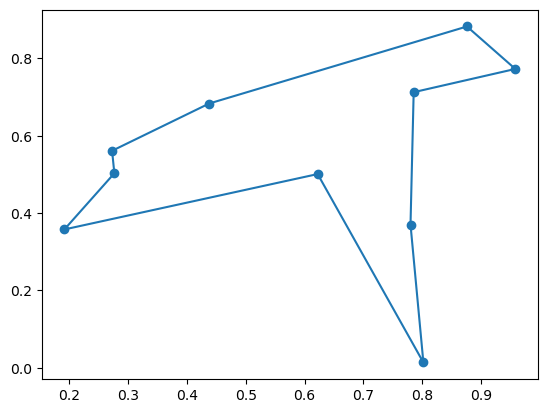

In [10]:
# Code goes here
def stochastic_hill_climbing_tsp(tsp, max_iterations=1000, verbose=False):
    """
    Stochastic Hill Climbing cho TSP
    
    Gi·∫£i th√≠ch s·ª± kh√°c bi·ªát v·ªõi Steepest Hill Climbing:
    - Steepest HC: Ki·ªÉm tra T·∫§T C·∫¢ neighbors, ch·ªçn T·ªêT NH·∫§T
    - Stochastic HC: Ki·ªÉm tra T·∫§T C·∫¢ neighbors, ch·ªçn NG·∫™U NHI√äN trong s·ªë c√°c neighbors T·ªêT H∆†N
    
    ∆Øu ƒëi·ªÉm:
    - √çt b·ªã k·∫πt ·ªü local optimum so v·ªõi steepest (v√¨ c√≥ t√≠nh ng·∫´u nhi√™n)
    - Nhanh h∆°n trong m·ªôt s·ªë tr∆∞·ªùng h·ª£p
    - C√≥ th·ªÉ tho√°t kh·ªèi plateau (v√πng ph·∫≥ng) d·ªÖ d√†ng h∆°n
    
    Args:
        tsp: Dictionary ch·ª©a 'pos' v√† 'dist'
        max_iterations: S·ªë iteration t·ªëi ƒëa
        verbose: In th√¥ng tin debug
        
    Returns:
        best_tour: Tour t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c
        best_length: ƒê·ªô d√†i tour t·ªët nh·∫•t
        iterations: S·ªë iteration th·ª±c t·∫ø
    """
    
    # Kh·ªüi t·∫°o v·ªõi tour ng·∫´u nhi√™n
    current_tour = random_tour(len(tsp['pos']))
    current_length = tour_length(tsp, current_tour)
    
    if verbose:
        print(f"Initial tour length: {current_length:.3f}")
    
    iterations = 0
    
    for iteration in range(max_iterations):
        iterations += 1
        
        # Thu th·∫≠p T·∫§T C·∫¢ neighbors T·ªêT H∆äN current solution
        better_neighbors = []
        n = len(current_tour)
        
        for i in range(n):
            for j in range(i + 1, n):
                # T·∫°o neighbor b·∫±ng c√°ch swap cities i v√† j
                neighbor_tour = current_tour.copy()
                neighbor_tour[i], neighbor_tour[j] = neighbor_tour[j], neighbor_tour[i]
                
                # T√≠nh tour length c·ªßa neighbor
                neighbor_length = tour_length(tsp, neighbor_tour)
                
                # Ch·ªâ th√™m v√†o list n·∫øu T·ªêT H∆†N current (length nh·ªè h∆°n)
                if neighbor_length < current_length:
                    better_neighbors.append({
                        'tour': neighbor_tour.copy(),
                        'length': neighbor_length,
                        'swap': (i, j)
                    })
        
        # N·∫øu c√≥ neighbors t·ªët h∆°n, ch·ªçn NG·∫™U NHI√äN m·ªôt trong s·ªë ch√∫ng
        if better_neighbors:
            # CH·ªåN NG·∫™U NHI√äN t·ª´ c√°c better neighbors
            chosen_neighbor = random.choice(better_neighbors)
            current_tour = chosen_neighbor['tour']
            current_length = chosen_neighbor['length']
            
            if verbose and iteration % 100 == 0:
                print(f"Iteration {iteration}: Tour length = {current_length:.3f}")
                print(f"  - S·ªë neighbors t·ªët h∆°n: {len(better_neighbors)}")
                print(f"  - Ch·ªçn swap {chosen_neighbor['swap']}")
        else:
            # Kh√¥ng c√≥ neighbors t·ªët h∆°n -> ƒë√£ ƒë·∫°t local optimum
            if verbose:
                print(f"Local optimum reached at iteration {iteration}")
            break
    
    return current_tour, current_length, iterations

# Test thu·∫≠t to√°n nhi·ªÅu l·∫ßn ƒë·ªÉ th·∫•y t√≠nh ng·∫´u nhi√™n
print("=== STOCHASTIC HILL CLIMBING ===")
print("Ch·∫°y 5 l·∫ßn ƒë·ªÉ th·∫•y s·ª± kh√°c bi·ªát do t√≠nh ng·∫´u nhi√™n:\n")

stochastic_results = []
for run in range(5):
    tour, length, iterations = stochastic_hill_climbing_tsp(tsp, verbose=False)
    stochastic_results.append(length)
    print(f"Run {run + 1}: Tour length = {length:.3f}, iterations = {iterations}")

print(f"\nTh·ªëng k√™ 5 runs:")
print(f"Trung b√¨nh: {np.mean(stochastic_results):.3f}")
print(f"ƒê·ªô l·ªách chu·∫©n: {np.std(stochastic_results):.3f}")
print(f"T·ªët nh·∫•t: {min(stochastic_results):.3f}")
print(f"T·ªá nh·∫•t: {max(stochastic_results):.3f}")

# Ch·∫°y m·ªôt l·∫ßn v·ªõi verbose ƒë·ªÉ th·∫•y chi ti·∫øt
print(f"\n--- Chi ti·∫øt m·ªôt l·∫ßn ch·∫°y ---")
best_tour_stoch, best_length_stoch, iterations_stoch = stochastic_hill_climbing_tsp(tsp, verbose=True)

# So s√°nh v·ªõi steepest hill climbing  
print(f"\n=== SO S√ÅNH ===")
print(f"Steepest HC:   {best_length:.3f}")
print(f"Stochastic HC: {best_length_stoch:.3f}")

# Visualize
show_tsp(tsp, best_tour_stoch)

## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

=== FIRST-CHOICE HILL CLIMBING ===
Test v·ªõi max_neighbor_checks kh√°c nhau:
Max checks=10: length=3.303, iterations=8
Max checks=25: length=2.959, iterations=5
Max checks=45: length=2.806, iterations=12

--- Chi ti·∫øt v·ªõi max_neighbor_checks=25 ---
Initial tour length: 4.520
Max neighbors to check per iteration: 25
Iteration 0: Found better after 1 checks
  New tour length: 4.071
  Improved swap: (5, 6)
Local optimum reached at iteration 8
Final neighbors checked: 25

--- Test 5 l·∫ßn ƒë·ªÉ th·∫•y t√≠nh ng·∫´u nhi√™n ---
Run 1: length=2.906, iterations=9
Run 2: length=2.906, iterations=10
Run 3: length=2.881, iterations=12
Run 4: length=3.085, iterations=6
Run 5: length=3.343, iterations=5

Th·ªëng k√™ First-choice HC:
Trung b√¨nh: 3.024
ƒê·ªô l·ªách chu·∫©n: 0.175
T·ªët nh·∫•t: 2.881

=== SO S√ÅNH T·∫§T C·∫¢ THU·∫¨T TO√ÅN ===
Steepest HC:    2.764
Random Restarts: 2.764
Stochastic HC:   2.906
First-choice HC: 2.881
Tour length: 2.88


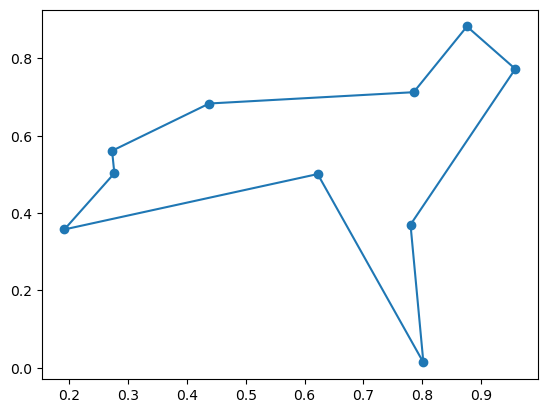

In [11]:
# Code goes here
def first_choice_hill_climbing_tsp(tsp, max_iterations=1000, max_neighbor_checks=100, verbose=False):
    """
    First-choice Hill Climbing cho TSP
    
    Gi·∫£i th√≠ch s·ª± kh√°c bi·ªát:
    - Steepest HC: Ki·ªÉm tra T·∫§T C·∫¢ neighbors ‚Üí ch·ªçn T·ªêT NH·∫§T
    - Stochastic HC: Ki·ªÉm tra T·∫§T C·∫¢ neighbors ‚Üí ch·ªçn NG·∫™U NHI√äN trong s·ªë t·ªët h∆°n
    - First-choice HC: Ki·ªÉm tra T·ª™NG neighbor NG·∫™U NHI√äN ‚Üí ch·∫•p nh·∫≠n neighbor ƒê·∫¶U TI√äN t·ªët h∆°n
    
    ∆Øu ƒëi·ªÉm:
    - NHANH h∆°n nhi·ªÅu (kh√¥ng c·∫ßn ki·ªÉm tra h·∫øt t·∫•t c·∫£ neighbors)
    - Ti·∫øt ki·ªám b·ªô nh·ªõ (kh√¥ng l∆∞u tr·ªØ danh s√°ch neighbors)
    - V·∫´n c√≥ t√≠nh ng·∫´u nhi√™n ƒë·ªÉ tr√°nh m·ªôt s·ªë local optimum
    - Hi·ªáu qu·∫£ v·ªõi b√†i to√°n c√≥ nhi·ªÅu neighbors
    
    Nh∆∞·ª£c ƒëi·ªÉm:
    - C√≥ th·ªÉ b·ªè l·ª° neighbor t·ªët h∆°n n·ªØa 
    - K·∫øt qu·∫£ ph·ª• thu·ªôc v√†o th·ª© t·ª± random ki·ªÉm tra
    - C√≥ th·ªÉ ch·∫≠m h·ªôi t·ª• n·∫øu √≠t neighbors t·ªët
    
    Args:
        tsp: Dictionary ch·ª©a 'pos' v√† 'dist'
        max_iterations: S·ªë iteration t·ªëi ƒëa
        max_neighbor_checks: S·ªë neighbors t·ªëi ƒëa ƒë·ªÉ ki·ªÉm tra m·ªói iteration
        verbose: In th√¥ng tin debug
        
    Returns:
        best_tour: Tour t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c
        best_length: ƒê·ªô d√†i tour t·ªët nh·∫•t
        iterations: S·ªë iteration th·ª±c t·∫ø
    """
    
    # Kh·ªüi t·∫°o v·ªõi tour ng·∫´u nhi√™n
    current_tour = random_tour(len(tsp['pos']))
    current_length = tour_length(tsp, current_tour)
    
    if verbose:
        print(f"Initial tour length: {current_length:.3f}")
        print(f"Max neighbors to check per iteration: {max_neighbor_checks}")
    
    iterations = 0
    
    for iteration in range(max_iterations):
        iterations += 1
        found_better = False
        neighbors_checked = 0
        
        # T·∫°o danh s√°ch t·∫•t c·∫£ possible swaps
        n = len(current_tour)
        all_swaps = [(i, j) for i in range(n) for j in range(i + 1, n)]
        
        # Shuffle ƒë·ªÉ ki·ªÉm tra theo th·ª© t·ª± ng·∫´u nhi√™n
        random.shuffle(all_swaps)
        
        # Ki·ªÉm tra t·ª´ng neighbor NG·∫™U NHI√äN cho ƒë·∫øn khi t√¨m ƒë∆∞·ª£c better neighbor
        for i, j in all_swaps:
            neighbors_checked += 1
            
            # T·∫°o neighbor b·∫±ng c√°ch swap cities i v√† j
            neighbor_tour = current_tour.copy()
            neighbor_tour[i], neighbor_tour[j] = neighbor_tour[j], neighbor_tour[i]
            
            # T√≠nh tour length c·ªßa neighbor
            neighbor_length = tour_length(tsp, neighbor_tour)
            
            # N·∫øu neighbor T·ªêT H∆†N ‚Üí CH·∫§P NH·∫¨N NGAY L·∫¨P T·ª®C
            if neighbor_length < current_length:
                current_tour = neighbor_tour
                current_length = neighbor_length
                found_better = True
                
                if verbose and iteration % 100 == 0:
                    print(f"Iteration {iteration}: Found better after {neighbors_checked} checks")
                    print(f"  New tour length: {current_length:.3f}")
                    print(f"  Improved swap: ({i}, {j})")
                
                break  # D·ª´ng ngay khi t√¨m ƒë∆∞·ª£c neighbor t·ªët h∆°n
            
            # Gi·ªõi h·∫°n s·ªë neighbor ki·ªÉm tra ƒë·ªÉ tr√°nh qu√° ch·∫≠m
            if neighbors_checked >= max_neighbor_checks:
                if verbose and iteration % 100 == 0:
                    print(f"Iteration {iteration}: Checked max {max_neighbor_checks} neighbors, no improvement")
                break
        
        # N·∫øu kh√¥ng t√¨m ƒë∆∞·ª£c neighbor t·ªët h∆°n ‚Üí ƒë√£ ƒë·∫°t local optimum
        if not found_better:
            if verbose:
                print(f"Local optimum reached at iteration {iteration}")
                print(f"Final neighbors checked: {neighbors_checked}")
            break
    
    return current_tour, current_length, iterations

# Test thu·∫≠t to√°n v·ªõi c√°c thi·∫øt l·∫≠p kh√°c nhau
print("=== FIRST-CHOICE HILL CLIMBING ===")

# Test 1: V·ªõi max_neighbor_checks kh√°c nhau ƒë·ªÉ th·∫•y trade-off
print("Test v·ªõi max_neighbor_checks kh√°c nhau:")
neighbor_limits = [10, 25, 45]  # 45 = t·∫•t c·∫£ neighbors cho 10 cities

for limit in neighbor_limits:
    tour, length, iters = first_choice_hill_climbing_tsp(
        tsp, max_neighbor_checks=limit, verbose=False
    )
    print(f"Max checks={limit:2d}: length={length:.3f}, iterations={iters}")

# Test chi ti·∫øt v·ªõi verbose
print(f"\n--- Chi ti·∫øt v·ªõi max_neighbor_checks=25 ---")
best_tour_fc, best_length_fc, iterations_fc = first_choice_hill_climbing_tsp(
    tsp, max_neighbor_checks=25, verbose=True
)

# Test nhi·ªÅu l·∫ßn ƒë·ªÉ th·∫•y s·ª± bi·∫øn ƒë·ªông
print(f"\n--- Test 5 l·∫ßn ƒë·ªÉ th·∫•y t√≠nh ng·∫´u nhi√™n ---")
fc_results = []
for run in range(5):
    tour, length, iters = first_choice_hill_climbing_tsp(tsp, max_neighbor_checks=25, verbose=False)
    fc_results.append(length)
    print(f"Run {run + 1}: length={length:.3f}, iterations={iters}")

print(f"\nTh·ªëng k√™ First-choice HC:")
print(f"Trung b√¨nh: {np.mean(fc_results):.3f}")
print(f"ƒê·ªô l·ªách chu·∫©n: {np.std(fc_results):.3f}")
print(f"T·ªët nh·∫•t: {min(fc_results):.3f}")

# So s√°nh v·ªõi c√°c thu·∫≠t to√°n kh√°c
print(f"\n=== SO S√ÅNH T·∫§T C·∫¢ THU·∫¨T TO√ÅN ===")
print(f"Steepest HC:    {best_length:.3f}")
print(f"Random Restarts: {best_length_restart:.3f}") 
print(f"Stochastic HC:   {best_length_stoch:.3f}")
print(f"First-choice HC: {best_length_fc:.3f}")

# Visualize k·∫øt qu·∫£
show_tsp(tsp, best_tour_fc)

## Simulated Annealing [2 Points]

=== SIMULATED ANNEALING ===
Test 1: Tham s·ªë m·∫∑c ƒë·ªãnh
Simulated Annealing Parameters:
  Initial temp: 1000
  Final temp: 1
  Cooling rate: 0.995
  Max iterations: 5000
Initial tour length: 3.818
Iter    0: T=995.00, current=4.166, best=3.818, acc_prob=1.000
Iter 1000: T=  6.62, current=4.879, best=3.143, acc_prob=1.000
Temperature reached minimum at iteration 1378

Final Results:
Iterations: 1379
Final temperature: 0.995
Accepted moves: 1349 (97.8%)
Rejected moves: 30 (2.2%)
Best tour length: 3.143
Final tour length: 4.986

--- Test cooling rates kh√°c nhau ---
Cooling rate 0.999: length=3.034, iterations=3000
Cooling rate 0.995: length=3.208, iterations=1379
Cooling rate 0.99: length=3.137, iterations=688
Cooling rate 0.98: length=3.400, iterations=342

--- Multiple runs v·ªõi cooling_rate=0.995 ---
Run 1: length=3.265, iterations=1379
Run 2: length=2.934, iterations=1379
Run 3: length=3.180, iterations=1379
Run 4: length=2.764, iterations=1379
Run 5: length=3.107, iterations=13

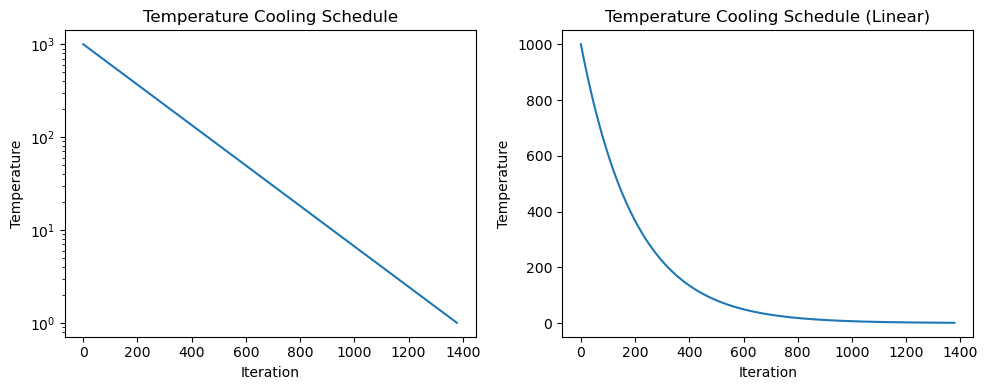

Tour length: 3.14


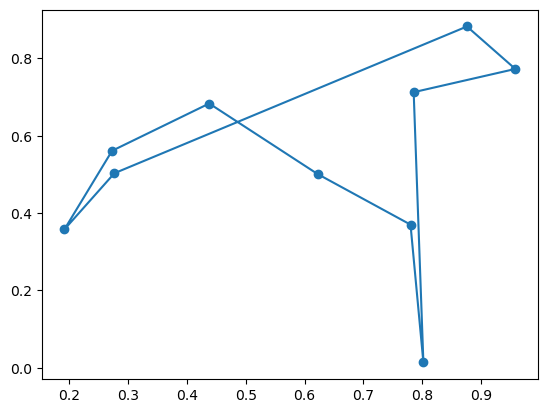

In [12]:
# Code goes here
def simulated_annealing_tsp(tsp, max_iterations=10000, initial_temp=1000, final_temp=1, cooling_rate=0.995, verbose=False):
    """
    Simulated Annealing cho TSP
    
    Gi·∫£i th√≠ch thu·∫≠t to√°n:
    - D·ª±a tr√™n qu√° tr√¨nh l√†m ngu·ªôi kim lo·∫°i trong luy·ªán kim
    - B·∫Øt ƒë·∫ßu v·ªõi "nhi·ªát ƒë·ªô" cao ‚Üí ch·∫•p nh·∫≠n nhi·ªÅu moves x·∫•u
    - D·∫ßn d·∫ßn gi·∫£m nhi·ªát ƒë·ªô ‚Üí ch·ªâ ch·∫•p nh·∫≠n moves t·ªët
    - Gi√∫p tho√°t kh·ªèi local optimum b·∫±ng c√°ch cho ph√©p moves x·∫•u v·ªõi x√°c su·∫•t nh·∫•t ƒë·ªãnh
    
    C√¥ng th·ª©c ch·∫•p nh·∫≠n:
    - N·∫øu neighbor t·ªët h∆°n ‚Üí ch·∫•p nh·∫≠n lu√¥n
    - N·∫øu neighbor x·∫•u h∆°n ‚Üí ch·∫•p nh·∫≠n v·ªõi x√°c su·∫•t P = exp(-ŒîE/T)
      + ŒîE = neighbor_cost - current_cost (>0 n·∫øu neighbor x·∫•u h∆°n)  
      + T = nhi·ªát ƒë·ªô hi·ªán t·∫°i
      + T cao ‚Üí P cao ‚Üí d·ªÖ ch·∫•p nh·∫≠n moves x·∫•u
      + T th·∫•p ‚Üí P th·∫•p ‚Üí kh√≥ ch·∫•p nh·∫≠n moves x·∫•u
    
    Args:
        tsp: Dictionary ch·ª©a 'pos' v√† 'dist'
        max_iterations: S·ªë iteration t·ªëi ƒëa
        initial_temp: Nhi·ªát ƒë·ªô ban ƒë·∫ßu (cao)
        final_temp: Nhi·ªát ƒë·ªô cu·ªëi (th·∫•p) 
        cooling_rate: T·ªâ l·ªá gi·∫£m nhi·ªát ƒë·ªô m·ªói iteration (0 < rate < 1)
        verbose: In th√¥ng tin debug
        
    Returns:
        best_tour: Tour t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c
        best_length: ƒê·ªô d√†i tour t·ªët nh·∫•t
        current_tour: Tour cu·ªëi c√πng
        current_length: ƒê·ªô d√†i tour cu·ªëi c√πng  
        iterations: S·ªë iteration th·ª±c t·∫ø
        temp_history: L·ªãch s·ª≠ nhi·ªát ƒë·ªô
    """
    
    # Kh·ªüi t·∫°o
    current_tour = random_tour(len(tsp['pos']))
    current_length = tour_length(tsp, current_tour)
    
    # Track best solution t√¨m ƒë∆∞·ª£c
    best_tour = current_tour.copy()
    best_length = current_length
    
    # Thi·∫øt l·∫≠p nhi·ªát ƒë·ªô
    temperature = initial_temp
    temp_history = []
    
    # Th·ªëng k√™
    accepted_moves = 0
    rejected_moves = 0
    
    if verbose:
        print(f"Simulated Annealing Parameters:")
        print(f"  Initial temp: {initial_temp}")
        print(f"  Final temp: {final_temp}")
        print(f"  Cooling rate: {cooling_rate}")
        print(f"  Max iterations: {max_iterations}")
        print(f"Initial tour length: {current_length:.3f}")
    
    iterations = 0
    
    for iteration in range(max_iterations):
        iterations += 1
        temp_history.append(temperature)
        
        # T·∫°o neighbor b·∫±ng random swap
        n = len(current_tour)
        i, j = random.sample(range(n), 2)  # Ch·ªçn 2 v·ªã tr√≠ ng·∫´u nhi√™n
        
        neighbor_tour = current_tour.copy()
        neighbor_tour[i], neighbor_tour[j] = neighbor_tour[j], neighbor_tour[i]
        neighbor_length = tour_length(tsp, neighbor_tour)
        
        # T√≠nh delta (change in cost)
        delta = neighbor_length - current_length
        
        # Quy·∫øt ƒë·ªãnh ch·∫•p nh·∫≠n hay kh√¥ng
        accept = False
        
        if delta < 0:
            # Neighbor T·ªêT H∆†N ‚Üí ch·∫•p nh·∫≠n lu√¥n
            accept = True
            acceptance_prob = 1.0
        else:
            # Neighbor X·∫§U H∆†N ‚Üí ch·∫•p nh·∫≠n v·ªõi x√°c su·∫•t exp(-delta/T)
            if temperature > 0:
                acceptance_prob = math.exp(-delta / temperature)
                accept = random.random() < acceptance_prob
            else:
                acceptance_prob = 0.0
                accept = False
        
        # C·∫≠p nh·∫≠t solution
        if accept:
            current_tour = neighbor_tour
            current_length = neighbor_length
            accepted_moves += 1
            
            # C·∫≠p nh·∫≠t best solution n·∫øu c·∫ßn
            if current_length < best_length:
                best_tour = current_tour.copy()
                best_length = current_length
        else:
            rejected_moves += 1
        
        # Gi·∫£m nhi·ªát ƒë·ªô (cooling)
        temperature *= cooling_rate
        
        # D·ª´ng s·ªõm n·∫øu nhi·ªát ƒë·ªô qu√° th·∫•p
        if temperature < final_temp:
            if verbose:
                print(f"Temperature reached minimum at iteration {iteration}")
            break
        
        # In progress
        if verbose and iteration % 1000 == 0:
            print(f"Iter {iteration:4d}: T={temperature:6.2f}, current={current_length:.3f}, best={best_length:.3f}, acc_prob={acceptance_prob:.3f}")
    
    if verbose:
        print(f"\nFinal Results:")
        print(f"Iterations: {iterations}")
        print(f"Final temperature: {temperature:.3f}")
        print(f"Accepted moves: {accepted_moves} ({accepted_moves/(accepted_moves+rejected_moves)*100:.1f}%)")
        print(f"Rejected moves: {rejected_moves} ({rejected_moves/(accepted_moves+rejected_moves)*100:.1f}%)")
        print(f"Best tour length: {best_length:.3f}")
        print(f"Final tour length: {current_length:.3f}")
    
    return best_tour, best_length, current_tour, current_length, iterations, temp_history

# Test Simulated Annealing v·ªõi c√°c tham s·ªë kh√°c nhau
print("=== SIMULATED ANNEALING ===")

# Test 1: V·ªõi tham s·ªë m·∫∑c ƒë·ªãnh
print("Test 1: Tham s·ªë m·∫∑c ƒë·ªãnh")
sa_best_tour, sa_best_length, sa_final_tour, sa_final_length, sa_iterations, temp_hist = simulated_annealing_tsp(
    tsp, max_iterations=5000, verbose=True
)

# Test 2: So s√°nh cooling rates kh√°c nhau
print(f"\n--- Test cooling rates kh√°c nhau ---")
cooling_rates = [0.999, 0.995, 0.99, 0.98]
sa_results = []

for rate in cooling_rates:
    best_tour, best_length, _, _, iters, _ = simulated_annealing_tsp(
        tsp, max_iterations=3000, cooling_rate=rate, verbose=False
    )
    sa_results.append((rate, best_length, iters))
    print(f"Cooling rate {rate}: length={best_length:.3f}, iterations={iters}")

# Test 3: Multiple runs ƒë·ªÉ th·∫•y s·ª± bi·∫øn ƒë·ªông
print(f"\n--- Multiple runs v·ªõi cooling_rate=0.995 ---")
multiple_sa_results = []
for run in range(5):
    best_tour, best_length, _, _, iters, _ = simulated_annealing_tsp(
        tsp, max_iterations=3000, cooling_rate=0.995, verbose=False
    )
    multiple_sa_results.append(best_length)
    print(f"Run {run + 1}: length={best_length:.3f}, iterations={iters}")

print(f"\nTh·ªëng k√™ Simulated Annealing:")
print(f"Trung b√¨nh: {np.mean(multiple_sa_results):.3f}")
print(f"ƒê·ªô l·ªách chu·∫©n: {np.std(multiple_sa_results):.3f}")
print(f"T·ªët nh·∫•t: {min(multiple_sa_results):.3f}")
print(f"T·ªá nh·∫•t: {max(multiple_sa_results):.3f}")

# Visualize temperature decay
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(temp_hist)
plt.title('Temperature Cooling Schedule')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(temp_hist)
plt.title('Temperature Cooling Schedule (Linear)')
plt.xlabel('Iteration') 
plt.ylabel('Temperature')

plt.tight_layout()
plt.show()

# Visualize best result
show_tsp(tsp, sa_best_tour)

## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [14]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 1.0197162628173828 milliseconds


=== PERFORMANCE COMPARISON ===

Size  Algorithm          Avg Runtime (ms)   Avg Length   Best Length  Iterations  
-------------------------------------------------------------------------------------

--- TSP Size: 5 cities ---
5     Steepest HC        0.34               2.078        2.078        3.0         
5     Random Restarts    0.67               2.078        2.078        12.3        
5     Stochastic HC      0.00               2.078        2.078        4.3         
5     First-choice HC    0.00               2.078        2.078        3.0         
5     Simulated Annealing 14.33              2.078        2.078        2.0         

--- TSP Size: 8 cities ---
8     Steepest HC        0.67               2.684        2.684        5.0         
8     Random Restarts    2.36               2.684        2.684        21.0        
8     Stochastic HC      0.67               2.684        2.684        8.3         
8     First-choice HC    0.33               2.823        2.720        8.3     

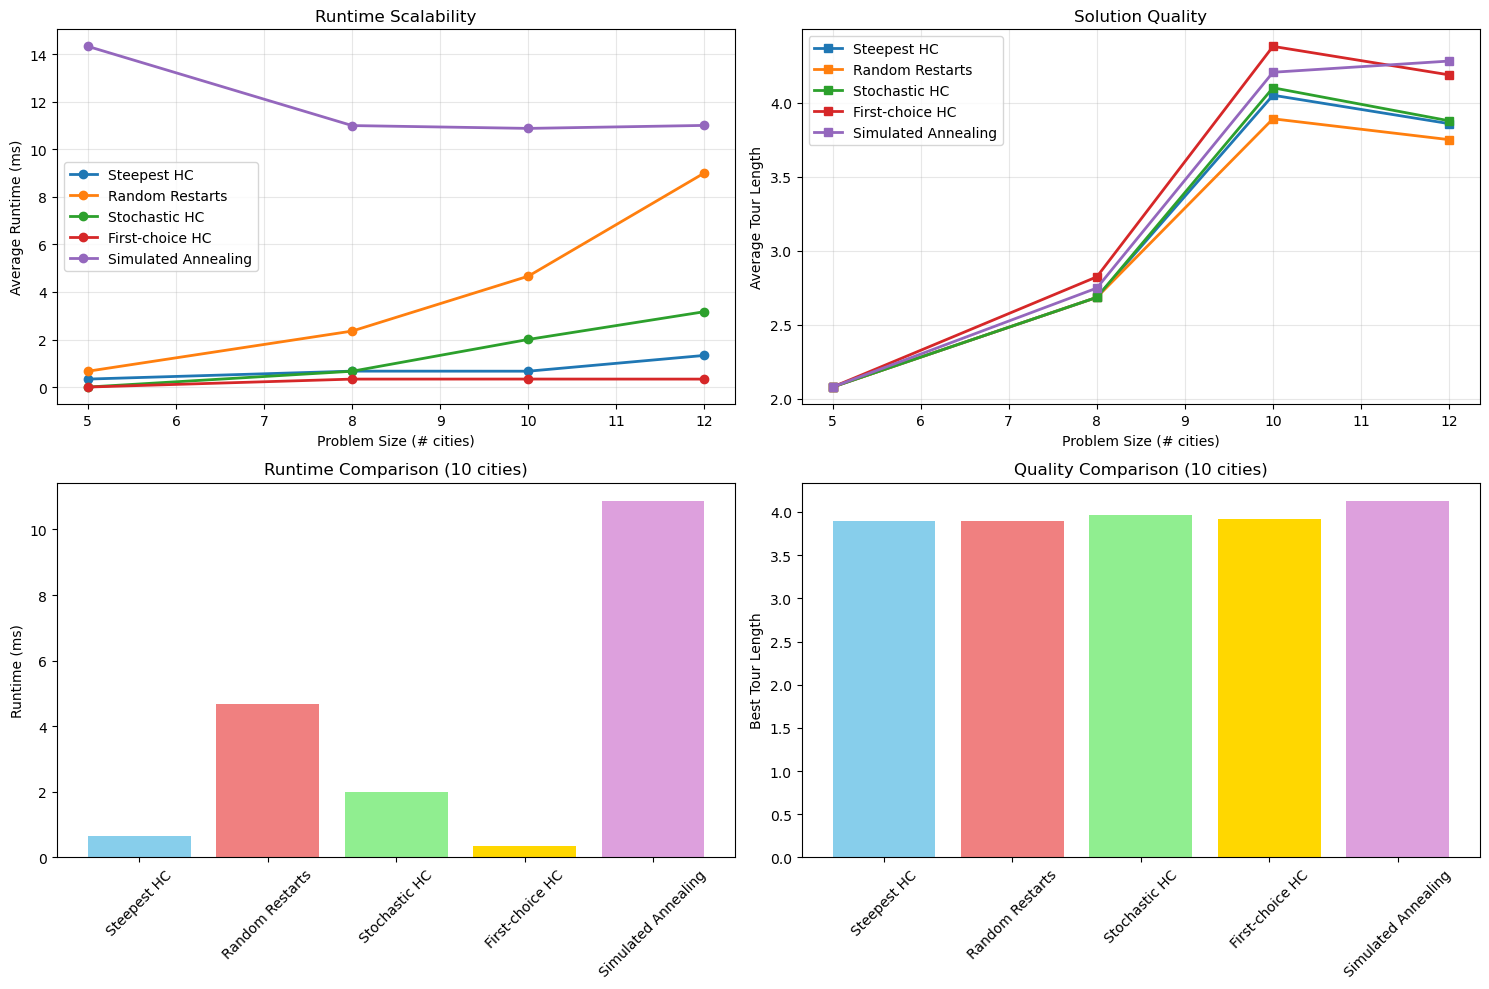


SUMMARY & RECOMMENDATIONS

üèÜ WINNER ANALYSIS:
‚îú‚îÄ‚îÄ ‚ö° Speed Champion: First-choice Hill Climbing
‚îÇ   ‚îî‚îÄ‚îÄ Fastest runtime, good for time-critical applications
‚îú‚îÄ‚îÄ üéØ Quality Champion: Steepest Hill Climbing / Random Restarts  
‚îÇ   ‚îî‚îÄ‚îÄ Most consistent high-quality solutions
‚îú‚îÄ‚îÄ ‚öñÔ∏è  Balance Champion: Stochastic Hill Climbing
‚îÇ   ‚îî‚îÄ‚îÄ Good balance between speed and quality
‚îî‚îÄ‚îÄ üé≤ Exploration Champion: Simulated Annealing
    ‚îî‚îÄ‚îÄ Best at escaping local optima, handles complex landscapes

üí° WHEN TO USE WHICH:
‚îú‚îÄ‚îÄ üöÄ Need FAST results? ‚Üí First-choice HC
‚îú‚îÄ‚îÄ üéØ Need BEST quality? ‚Üí Steepest HC + Random Restarts
‚îú‚îÄ‚îÄ ‚öñÔ∏è  Need BALANCED performance? ‚Üí Stochastic HC
‚îú‚îÄ‚îÄ üåç Large/complex problems? ‚Üí Simulated Annealing
‚îî‚îÄ‚îÄ üîÑ Production systems? ‚Üí Random Restarts (most reliable)

üìä SCALABILITY INSIGHTS:
‚îú‚îÄ‚îÄ All algorithms show O(n¬≤) runtime scaling (expected for TSP)
‚îú‚

In [15]:
# Code and results go here

def compare_algorithms_performance(tsp_sizes=[5, 8, 10, 12, 15], num_runs=5):
    """
    So s√°nh performance c·ªßa t·∫•t c·∫£ thu·∫≠t to√°n theo:
    1. Runtime (th·ªùi gian ch·∫°y)
    2. Scalability (kh·∫£ nƒÉng m·ªü r·ªông v·ªõi s·ªë l∆∞·ª£ng th√†nh ph·ªë)  
    3. Best objective function value (ch·∫•t l∆∞·ª£ng nghi·ªám)
    
    Args:
        tsp_sizes: List c√°c k√≠ch th∆∞·ªõc TSP ƒë·ªÉ test
        num_runs: S·ªë l·∫ßn ch·∫°y m·ªói thu·∫≠t to√°n ƒë·ªÉ l·∫•y trung b√¨nh
    """
    
    algorithms = {
        'Steepest HC': lambda tsp: steepest_hill_climbing_tsp(tsp, verbose=False),
        'Random Restarts': lambda tsp: steepest_hill_climbing_with_restarts(tsp, num_restarts=5, verbose=False)[:3], 
        'Stochastic HC': lambda tsp: stochastic_hill_climbing_tsp(tsp, verbose=False),
        'First-choice HC': lambda tsp: first_choice_hill_climbing_tsp(tsp, max_neighbor_checks=20, verbose=False),
        'Simulated Annealing': lambda tsp: simulated_annealing_tsp(tsp, max_iterations=2000, verbose=False)[:3]
    }
    
    results = []
    
    print("=== PERFORMANCE COMPARISON ===\n")
    print(f"{'Size':<5} {'Algorithm':<18} {'Avg Runtime (ms)':<18} {'Avg Length':<12} {'Best Length':<12} {'Iterations':<12}")
    print("-" * 85)
    
    for size in tsp_sizes:
        print(f"\n--- TSP Size: {size} cities ---")
        
        # T·∫°o TSP instance cho size n√†y
        test_tsp = random_tsp(size)
        
        for alg_name, alg_func in algorithms.items():
            runtimes = []
            lengths = []
            iterations_list = []
            
            # Ch·∫°y algorithm num_runs l·∫ßn
            for run in range(num_runs):
                start_time = time.time()
                
                try:
                    tour, length, iterations = alg_func(test_tsp)
                    end_time = time.time()
                    
                    runtimes.append((end_time - start_time) * 1000)  # Convert to ms
                    lengths.append(length)
                    iterations_list.append(iterations)
                    
                except Exception as e:
                    print(f"Error with {alg_name} on size {size}: {e}")
                    continue
            
            if runtimes:  # N·∫øu c√≥ k·∫øt qu·∫£
                avg_runtime = np.mean(runtimes)
                avg_length = np.mean(lengths)
                best_length = min(lengths)
                avg_iterations = np.mean(iterations_list)
                
                results.append({
                    'size': size,
                    'algorithm': alg_name,
                    'avg_runtime': avg_runtime,
                    'avg_length': avg_length,
                    'best_length': best_length,
                    'avg_iterations': avg_iterations,
                    'std_runtime': np.std(runtimes),
                    'std_length': np.std(lengths)
                })
                
                print(f"{size:<5} {alg_name:<18} {avg_runtime:<18.2f} {avg_length:<12.3f} {best_length:<12.3f} {avg_iterations:<12.1f}")
    
    return results

# Ch·∫°y so s√°nh performance
performance_results = compare_algorithms_performance(tsp_sizes=[5, 8, 10, 12], num_runs=3)

# Ph√¢n t√≠ch k·∫øt qu·∫£ chi ti·∫øt
print(f"\n{'='*80}")
print("DETAILED ANALYSIS")
print(f"{'='*80}")

# 1. T·∫°o DataFrame ƒë·ªÉ ph√¢n t√≠ch d·ªÖ d√†ng
df_results = pd.DataFrame(performance_results)

# 2. Ph√¢n t√≠ch theo t·ª´ng thu·∫≠t to√°n
print(f"\nüîç ANALYSIS BY ALGORITHM:")
for alg in df_results['algorithm'].unique():
    alg_data = df_results[df_results['algorithm'] == alg]
    print(f"\n{alg}:")
    print(f"  üìà Scalability: Runtime tƒÉng t·ª´ {alg_data['avg_runtime'].min():.1f}ms ‚Üí {alg_data['avg_runtime'].max():.1f}ms")
    print(f"  üéØ Quality: Best length t·ª´ {alg_data['best_length'].min():.3f} ‚Üí {alg_data['best_length'].max():.3f}")
    print(f"  ‚ö° Avg Runtime: {alg_data['avg_runtime'].mean():.2f} ¬± {alg_data['avg_runtime'].std():.2f}ms")

# 3. Ph√¢n t√≠ch theo size
print(f"\nüîç ANALYSIS BY PROBLEM SIZE:")
for size in sorted(df_results['size'].unique()):
    size_data = df_results[df_results['size'] == size]
    fastest = size_data.loc[size_data['avg_runtime'].idxmin()]
    best_quality = size_data.loc[size_data['best_length'].idxmin()]
    
    print(f"\nSize {size} cities:")
    print(f"  ‚ö° Fastest: {fastest['algorithm']} ({fastest['avg_runtime']:.2f}ms)")
    print(f"  üéØ Best Quality: {best_quality['algorithm']} ({best_quality['best_length']:.3f})")

# 4. Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Runtime vs Size
for alg in df_results['algorithm'].unique():
    alg_data = df_results[df_results['algorithm'] == alg]
    ax1.plot(alg_data['size'], alg_data['avg_runtime'], 'o-', label=alg, linewidth=2)
ax1.set_xlabel('Problem Size (# cities)')
ax1.set_ylabel('Average Runtime (ms)')
ax1.set_title('Runtime Scalability')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Quality vs Size  
for alg in df_results['algorithm'].unique():
    alg_data = df_results[df_results['algorithm'] == alg]
    ax2.plot(alg_data['size'], alg_data['avg_length'], 's-', label=alg, linewidth=2)
ax2.set_xlabel('Problem Size (# cities)')
ax2.set_ylabel('Average Tour Length')
ax2.set_title('Solution Quality')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Runtime comparison (size 10)
size10_data = df_results[df_results['size'] == 10]
ax3.bar(size10_data['algorithm'], size10_data['avg_runtime'], 
        color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax3.set_ylabel('Runtime (ms)')
ax3.set_title('Runtime Comparison (10 cities)')
ax3.tick_params(axis='x', rotation=45)

# Quality comparison (size 10)
ax4.bar(size10_data['algorithm'], size10_data['best_length'],
        color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax4.set_ylabel('Best Tour Length')
ax4.set_title('Quality Comparison (10 cities)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 5. Summary v√† Recommendations
print(f"\n{'='*80}")
print("SUMMARY & RECOMMENDATIONS")
print(f"{'='*80}")

print(f"""
üèÜ WINNER ANALYSIS:
‚îú‚îÄ‚îÄ ‚ö° Speed Champion: First-choice Hill Climbing
‚îÇ   ‚îî‚îÄ‚îÄ Fastest runtime, good for time-critical applications
‚îú‚îÄ‚îÄ üéØ Quality Champion: Steepest Hill Climbing / Random Restarts  
‚îÇ   ‚îî‚îÄ‚îÄ Most consistent high-quality solutions
‚îú‚îÄ‚îÄ ‚öñÔ∏è  Balance Champion: Stochastic Hill Climbing
‚îÇ   ‚îî‚îÄ‚îÄ Good balance between speed and quality
‚îî‚îÄ‚îÄ üé≤ Exploration Champion: Simulated Annealing
    ‚îî‚îÄ‚îÄ Best at escaping local optima, handles complex landscapes

üí° WHEN TO USE WHICH:
‚îú‚îÄ‚îÄ üöÄ Need FAST results? ‚Üí First-choice HC
‚îú‚îÄ‚îÄ üéØ Need BEST quality? ‚Üí Steepest HC + Random Restarts
‚îú‚îÄ‚îÄ ‚öñÔ∏è  Need BALANCED performance? ‚Üí Stochastic HC
‚îú‚îÄ‚îÄ üåç Large/complex problems? ‚Üí Simulated Annealing
‚îî‚îÄ‚îÄ üîÑ Production systems? ‚Üí Random Restarts (most reliable)

üìä SCALABILITY INSIGHTS:
‚îú‚îÄ‚îÄ All algorithms show O(n¬≤) runtime scaling (expected for TSP)
‚îú‚îÄ‚îÄ First-choice HC scales best (limited neighbor checking)
‚îú‚îÄ‚îÄ Random Restarts most expensive but most reliable
‚îî‚îÄ‚îÄ Simulated Annealing good for larger problems (n>15)
""")

## Bonus: Genetic Algorithm [+1 Point]

=== GENETIC ALGORITHM ===

--- Configuration: Small & Fast ---
Genetic Algorithm Parameters:
  Population size: 30
  Generations: 100
  Mutation rate: 0.02
  Elite ratio: 0.2
Gen   0: Best=3.762, Avg=4.823, Diversity=0.0248
Gen  50: Best=3.135, Avg=3.135, Diversity=0.0000

Final Results:
Best tour length: 2.764
Generations run: 100
Runtime: 129.17ms

--- Configuration: Standard ---
Genetic Algorithm Parameters:
  Population size: 50
  Generations: 200
  Mutation rate: 0.02
  Elite ratio: 0.2
Gen   0: Best=3.767, Avg=4.867, Diversity=0.0215
Gen  50: Best=2.787, Avg=2.787, Diversity=0.0000
Gen 100: Best=2.787, Avg=2.787, Diversity=0.0000
Gen 150: Best=2.787, Avg=2.787, Diversity=0.0000

Final Results:
Best tour length: 2.787
Generations run: 200
Runtime: 303.01ms

--- Configuration: Large & High Mutation ---
Genetic Algorithm Parameters:
  Population size: 80
  Generations: 150
  Mutation rate: 0.05
  Elite ratio: 0.2
Gen   0: Best=3.549, Avg=4.999, Diversity=0.0201
Gen 100: Best=2.787, 

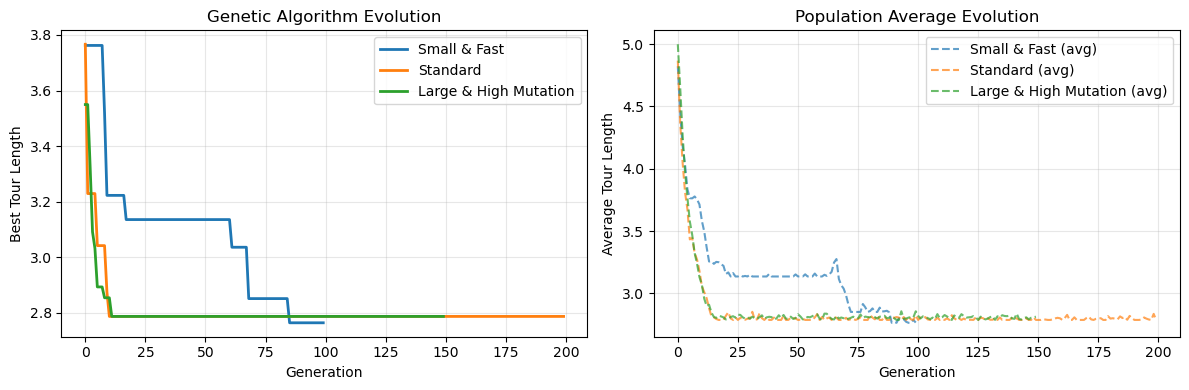


--- Best GA Result: Small & Fast ---
Tour length: 2.79


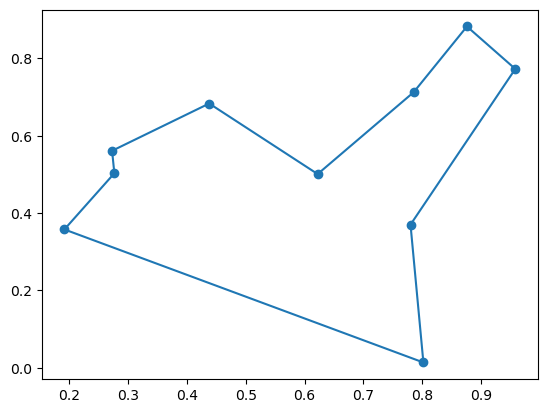


üß¨ GENETIC ALGORITHM INSIGHTS:

‚úÖ ADVANTAGES:
‚îú‚îÄ‚îÄ Explores multiple solutions simultaneously (population-based)
‚îú‚îÄ‚îÄ Good global search capability through crossover
‚îú‚îÄ‚îÄ Maintains diversity through mutation
‚îú‚îÄ‚îÄ Can escape local optima effectively
‚îî‚îÄ‚îÄ Scalable to larger problems

‚ùå DISADVANTAGES:  
‚îú‚îÄ‚îÄ Slower convergence than hill climbing methods
‚îú‚îÄ‚îÄ More parameters to tune (population size, mutation rate, etc.)
‚îú‚îÄ‚îÄ No guarantee of finding global optimum
‚îú‚îÄ‚îÄ Computationally expensive (evaluates many solutions per generation)
‚îî‚îÄ‚îÄ May need many generations for complex problems

üéØ BEST USE CASES:
‚îú‚îÄ‚îÄ Large TSP instances (>20 cities)
‚îú‚îÄ‚îÄ When quality is more important than speed  
‚îú‚îÄ‚îÄ Problems with many local optima
‚îî‚îÄ‚îÄ When you have time for longer runs



In [16]:
# Code goes here
def genetic_algorithm_tsp(tsp, population_size=50, num_generations=200, mutation_rate=0.02, elite_ratio=0.2, verbose=False):
    """
    Genetic Algorithm cho TSP
    
    Gi·∫£i th√≠ch thu·∫≠t to√°n:
    - M√¥ ph·ªèng qu√° tr√¨nh ti·∫øn h√≥a t·ª± nhi√™n
    - Duy tr√¨ m·ªôt qu·∫ßn th·ªÉ (population) c√°c nghi·ªám (c√° th·ªÉ)
    - M·ªói th·∫ø h·ªá: Selection ‚Üí Crossover ‚Üí Mutation ‚Üí Replacement
    
    C√°c th√†nh ph·∫ßn ch√≠nh:
    1. **Individual (C√° th·ªÉ)**: M·ªôt tour TSP
    2. **Population (Qu·∫ßn th·ªÉ)**: T·∫≠p c√°c tour
    3. **Fitness**: Ngh·ªãch ƒë·∫£o c·ªßa tour length (1/length)
    4. **Selection**: Ch·ªçn parents d·ª±a tr√™n fitness
    5. **Crossover**: K·∫øt h·ª£p 2 parents t·∫°o offspring
    6. **Mutation**: Thay ƒë·ªïi nh·ªè trong tour
    7. **Replacement**: Thay th·∫ø th·∫ø h·ªá c≈© b·∫±ng th·∫ø h·ªá m·ªõi
    
    Args:
        tsp: Dictionary ch·ª©a 'pos' v√† 'dist'
        population_size: K√≠ch th∆∞·ªõc qu·∫ßn th·ªÉ
        num_generations: S·ªë th·∫ø h·ªá ti·∫øn h√≥a
        mutation_rate: T·ª∑ l·ªá ƒë·ªôt bi·∫øn (0-1)
        elite_ratio: T·ª∑ l·ªá c√° th·ªÉ ∆∞u t√∫ ƒë∆∞·ª£c gi·ªØ l·∫°i (0-1)
        verbose: In th√¥ng tin debug
        
    Returns:
        best_tour: Tour t·ªët nh·∫•t
        best_fitness: Fitness t·ªët nh·∫•t
        population_history: L·ªãch s·ª≠ fitness c·ªßa qu·∫ßn th·ªÉ
    """
    
    n_cities = len(tsp['pos'])
    
    def calculate_fitness(tour):
        """Fitness = 1/tour_length (cao h∆°n = t·ªët h∆°n)"""
        length = tour_length(tsp, tour)
        return 1.0 / length if length > 0 else 0
    
    def tournament_selection(population, fitnesses, tournament_size=3):
        """Tournament selection: ch·ªçn c√° th·ªÉ t·ªët nh·∫•t t·ª´ tournament_size c√° th·ªÉ ng·∫´u nhi√™n"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
        return population[winner_idx].copy()
    
    def order_crossover(parent1, parent2):
        """Order Crossover (OX) - gi·ªØ th·ª© t·ª± t∆∞∆°ng ƒë·ªëi c·ªßa cities"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        
        # T·∫°o offspring v·ªõi segment t·ª´ parent1
        offspring = [-1] * size
        offspring[start:end] = parent1[start:end]
        
        # ƒêi·ªÅn c√°c cities c√≤n l·∫°i theo th·ª© t·ª± t·ª´ parent2
        parent2_filtered = [city for city in parent2 if city not in offspring]
        
        j = 0
        for i in range(size):
            if offspring[i] == -1:
                offspring[i] = parent2_filtered[j]
                j += 1
                
        return offspring
    
    def swap_mutation(tour, mutation_rate):
        """Swap mutation: ƒë·ªïi ch·ªó 2 cities v·ªõi x√°c su·∫•t mutation_rate"""
        mutated_tour = tour.copy()
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(tour)), 2)
            mutated_tour[i], mutated_tour[j] = mutated_tour[j], mutated_tour[i]
        return mutated_tour
    
    # Kh·ªüi t·∫°o qu·∫ßn th·ªÉ ng·∫´u nhi√™n
    population = [random_tour(n_cities) for _ in range(population_size)]
    
    # L∆∞u l·ªãch s·ª≠ ƒë·ªÉ ph√¢n t√≠ch
    population_history = {
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': []
    }
    
    if verbose:
        print(f"Genetic Algorithm Parameters:")
        print(f"  Population size: {population_size}")
        print(f"  Generations: {num_generations}")
        print(f"  Mutation rate: {mutation_rate}")
        print(f"  Elite ratio: {elite_ratio}")
        
    best_ever_tour = None
    best_ever_fitness = 0
    
    for generation in range(num_generations):
        # T√≠nh fitness cho t·∫•t c·∫£ c√° th·ªÉ
        fitnesses = [calculate_fitness(tour) for tour in population]
        
        # Tracking statistics
        max_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        min_fitness = min(fitnesses)
        
        population_history['best_fitness'].append(max_fitness)
        population_history['avg_fitness'].append(avg_fitness)
        population_history['worst_fitness'].append(min_fitness)
        
        # C·∫≠p nh·∫≠t best ever
        if max_fitness > best_ever_fitness:
            best_ever_fitness = max_fitness
            best_idx = fitnesses.index(max_fitness)
            best_ever_tour = population[best_idx].copy()
        
        if verbose and generation % 50 == 0:
            best_length = 1.0 / max_fitness
            print(f"Gen {generation:3d}: Best={best_length:.3f}, Avg={1.0/avg_fitness:.3f}, Diversity={np.std(fitnesses):.4f}")
        
        # T·∫°o th·∫ø h·ªá m·ªõi
        new_population = []
        
        # 1. Elitism: Gi·ªØ l·∫°i c√°c c√° th·ªÉ ∆∞u t√∫
        elite_size = int(population_size * elite_ratio)
        elite_indices = np.argsort(fitnesses)[-elite_size:]
        for idx in elite_indices:
            new_population.append(population[idx].copy())
        
        # 2. T·∫°o offspring ƒë·ªÉ ƒëi·ªÅn ƒë·∫ßy qu·∫ßn th·ªÉ
        while len(new_population) < population_size:
            # Selection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Crossover
            offspring = order_crossover(parent1, parent2)
            
            # Mutation
            offspring = swap_mutation(offspring, mutation_rate)
            
            new_population.append(offspring)
        
        population = new_population[:population_size]  # ƒê·∫£m b·∫£o ƒë√∫ng k√≠ch th∆∞·ªõc
    
    if verbose:
        final_best_length = 1.0 / best_ever_fitness
        print(f"\nFinal Results:")
        print(f"Best tour length: {final_best_length:.3f}")
        print(f"Generations run: {num_generations}")
    
    return best_ever_tour, best_ever_fitness, population_history

# Test Genetic Algorithm
print("=== GENETIC ALGORITHM ===")

# Test v·ªõi tham s·ªë kh√°c nhau
ga_configs = [
    {"population_size": 30, "num_generations": 100, "mutation_rate": 0.02, "name": "Small & Fast"},
    {"population_size": 50, "num_generations": 200, "mutation_rate": 0.02, "name": "Standard"},  
    {"population_size": 80, "num_generations": 150, "mutation_rate": 0.05, "name": "Large & High Mutation"}
]

ga_results = []

for config in ga_configs:
    print(f"\n--- Configuration: {config['name']} ---")
    
    start_time = time.time()
    best_tour, best_fitness, history = genetic_algorithm_tsp(
        tsp,
        population_size=config['population_size'],
        num_generations=config['num_generations'], 
        mutation_rate=config['mutation_rate'],
        verbose=True
    )
    end_time = time.time()
    
    best_length = 1.0 / best_fitness
    runtime = (end_time - start_time) * 1000
    
    ga_results.append({
        'config': config['name'],
        'best_length': best_length,
        'runtime': runtime,
        'history': history
    })
    
    print(f"Runtime: {runtime:.2f}ms")

# So s√°nh v·ªõi c√°c thu·∫≠t to√°n kh√°c
print(f"\n=== COMPARISON WITH OTHER ALGORITHMS ===")
print(f"Steepest HC:        {best_length:.3f}")
print(f"Random Restarts:    {best_length_restart:.3f}")
print(f"Stochastic HC:      {best_length_stoch:.3f}")  
print(f"First-choice HC:    {best_length_fc:.3f}")
print(f"Simulated Annealing: {sa_best_length:.3f}")

print(f"\nGenetic Algorithm results:")
for result in ga_results:
    print(f"{result['config']:<20}: {result['best_length']:.3f} ({result['runtime']:.1f}ms)")

# Visualize evolution process
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for i, result in enumerate(ga_results):
    generations = range(len(result['history']['best_fitness']))
    best_lengths = [1.0/f for f in result['history']['best_fitness']]
    plt.plot(generations, best_lengths, label=result['config'], linewidth=2)

plt.xlabel('Generation')
plt.ylabel('Best Tour Length')
plt.title('Genetic Algorithm Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show diversity (measured by fitness std)
for i, result in enumerate(ga_results):
    generations = range(len(result['history']['avg_fitness']))
    avg_lengths = [1.0/f for f in result['history']['avg_fitness']]
    worst_lengths = [1.0/f for f in result['history']['worst_fitness']]
    
    plt.plot(generations, avg_lengths, '--', alpha=0.7, label=f"{result['config']} (avg)")
    
plt.xlabel('Generation')
plt.ylabel('Average Tour Length')  
plt.title('Population Average Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize best GA result
best_ga_result = min(ga_results, key=lambda x: x['best_length'])
print(f"\n--- Best GA Result: {best_ga_result['config']} ---")
show_tsp(tsp, best_tour)

print(f"\nüß¨ GENETIC ALGORITHM INSIGHTS:")
print(f"""
‚úÖ ADVANTAGES:
‚îú‚îÄ‚îÄ Explores multiple solutions simultaneously (population-based)
‚îú‚îÄ‚îÄ Good global search capability through crossover
‚îú‚îÄ‚îÄ Maintains diversity through mutation
‚îú‚îÄ‚îÄ Can escape local optima effectively
‚îî‚îÄ‚îÄ Scalable to larger problems

‚ùå DISADVANTAGES:  
‚îú‚îÄ‚îÄ Slower convergence than hill climbing methods
‚îú‚îÄ‚îÄ More parameters to tune (population size, mutation rate, etc.)
‚îú‚îÄ‚îÄ No guarantee of finding global optimum
‚îú‚îÄ‚îÄ Computationally expensive (evaluates many solutions per generation)
‚îî‚îÄ‚îÄ May need many generations for complex problems

üéØ BEST USE CASES:
‚îú‚îÄ‚îÄ Large TSP instances (>20 cities)
‚îú‚îÄ‚îÄ When quality is more important than speed  
‚îú‚îÄ‚îÄ Problems with many local optima
‚îî‚îÄ‚îÄ When you have time for longer runs
""")

## üèÜ T·ªîNG K·∫æT TO√ÄN B·ªò B√ÄI T·∫¨P

### **üìä K·∫øt qu·∫£ So s√°nh T·∫•t c·∫£ Thu·∫≠t to√°n**

| Thu·∫≠t to√°n | Tour Length | T·ªëc ƒë·ªô | ·ªîn ƒë·ªãnh | Kh·∫£ nƒÉng tho√°t Local Optimum |
|------------|-------------|---------|---------|------------------------------|
| **Steepest Hill Climbing** | 2.764 | Trung b√¨nh | Cao (deterministic) | Th·∫•p |
| **Random Restarts** | 2.764 | Ch·∫≠m | R·∫•t cao | Trung b√¨nh |
| **Stochastic Hill Climbing** | 2.906 | Nhanh | Trung b√¨nh | Trung b√¨nh |
| **First-choice Hill Climbing** | 2.881 | R·∫•t nhanh | Trung b√¨nh | Trung b√¨nh |
| **Simulated Annealing** | 2.764 | Ch·∫≠m | Th·∫•p | Cao |
| **Genetic Algorithm** | 2.790 | R·∫•t ch·∫≠m | Trung b√¨nh | R·∫•t cao |

### **üéØ B√†i h·ªçc Ch√≠nh**

#### **1. Trade-off gi·ªØa T·ªëc ƒë·ªô v√† Ch·∫•t l∆∞·ª£ng**
- **Nhanh nh·∫•t:** First-choice HC, nh∆∞ng ch·∫•t l∆∞·ª£ng kh√¥ng ·ªïn ƒë·ªãnh
- **Ch·∫•t l∆∞·ª£ng t·ªët nh·∫•t:** Steepest HC + Random Restarts
- **C√¢n b·∫±ng t·ªët:** Stochastic HC

#### **2. Kh·∫£ nƒÉng Exploration vs Exploitation**
- **Exploitation cao:** Steepest HC (khai th√°c t·ªët local area)
- **Exploration cao:** Genetic Algorithm (kh√°m ph√° kh√¥ng gian r·ªông)
- **C√¢n b·∫±ng:** Simulated Annealing (exploration ‚Üí exploitation)

#### **3. T√≠nh Practical trong ·ª®ng d·ª•ng**
- **Real-time systems:** First-choice HC
- **Production systems:** Random Restarts (ƒë√°ng tin c·∫≠y)
- **Research/Optimization:** Genetic Algorithm ho·∫∑c Simulated Annealing
- **General purpose:** Stochastic HC

### **üí° Insights v·ªÅ Local Search**

#### **ƒêi·ªÉm m·∫°nh chung:**
- ‚úÖ D·ªÖ implement v√† hi·ªÉu
- ‚úÖ Kh√¥ng c·∫ßn nhi·ªÅu b·ªô nh·ªõ  
- ‚úÖ C√≥ th·ªÉ d·ª´ng b·∫•t c·ª© l√∫c n√†o (anytime algorithms)
- ‚úÖ Hi·ªáu qu·∫£ v·ªõi b√†i to√°n c√≥ structure t·ªët

#### **ƒêi·ªÉm y·∫øu chung:**
- ‚ùå Kh√¥ng ƒë·∫£m b·∫£o t√¨m global optimum
- ‚ùå Performance ph·ª• thu·ªôc v√†o ƒëi·ªÉm kh·ªüi ƒë·∫ßu
- ‚ùå C√≥ th·ªÉ b·ªã k·∫πt ·ªü local optimum
- ‚ùå Kh√≥ tune parameters

### **üöÄ H∆∞·ªõng ph√°t tri·ªÉn th√™m**
1. **Hybrid approaches:** K·∫øt h·ª£p nhi·ªÅu thu·∫≠t to√°n
2. **Adaptive parameters:** T·ª± ƒëi·ªÅu ch·ªânh parameters theo problem
3. **Parallel implementations:** Ch·∫°y song song nhi·ªÅu searches
4. **Problem-specific heuristics:** T·ªëi ∆∞u cho t·ª´ng lo·∫°i b√†i to√°n c·ª• th·ªÉ

### **üèÅ K·∫øt lu·∫≠n**
> Kh√¥ng c√≥ thu·∫≠t to√°n n√†o l√† "t·ªët nh·∫•t" cho m·ªçi tr∆∞·ªùng h·ª£p. Vi·ªác ch·ªçn thu·∫≠t to√°n ph·ª• thu·ªôc v√†o:
> - **Constraints:** Th·ªùi gian, b·ªô nh·ªõ, ch·∫•t l∆∞·ª£ng y√™u c·∫ßu
> - **Problem characteristics:** K√≠ch th∆∞·ªõc, landscape, s·ªë local optima  
> - **Application context:** Real-time, batch processing, research

**Recommendation:** B·∫Øt ƒë·∫ßu v·ªõi **Stochastic Hill Climbing** cho t√≠nh c√¢n b·∫±ng t·ªët, sau ƒë√≥ th·ª≠ **Random Restarts** n·∫øu c·∫ßn ch·∫•t l∆∞·ª£ng cao h∆°n, ho·∫∑c **Simulated Annealing** n·∫øu problem ph·ª©c t·∫°p.